In [1]:
%matplotlib inline
%matplotlib widget 

import numpy as np
from scipy.spatial.transform import Rotation as R
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial.distance import euclidean
from scipy.optimize import minimize
from functools import partial

In [2]:
def plot_3d(x, y, z):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x[0], y[0], z[0], c='r', marker='*')
    ax.scatter(x[1:].flatten(), y[1:].flatten(), z[1:].flatten(), c='b', marker='o')
    
    # Draw a line
    def draw_line(ax, prev_p, next_p):
        ax.plot([prev_p[0], next_p[0]], [prev_p[1], next_p[1]], [prev_p[2], next_p[2]], c='b')
        return ax

    for joint_i in range(1, x.shape[0]):
        if (joint_i - 1) % 4 == 0:
            prev_p = [x[0], y[0], z[0]]
        else:
            prev_p = next_p
        next_p = [x[joint_i], y[joint_i], z[joint_i]]
        ax = draw_line(ax, prev_p, next_p)

    # Draw Oxyz coord
    ax.plot([0, 20], [0, 0], [0, 0], c='r')
    ax.plot([0, 0], [0, 20], [0, 0], c='g')
    ax.plot([0, 0], [0, 0], [0, 20], c='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the limits for each axis
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_zlim(np.min(z), np.max(z))  # Setting custom limits for z-axis
    plt.show()
    #return ax

In [3]:
oak_data = np.load('./camera_calibration/oak_calibration.npz')
rs_data = np.load('./camera_calibration/rs_calibration.npz')

In [4]:
oak_r_raw, oak_t_raw, oak_ins = oak_data['rvecs'], oak_data['tvecs'], oak_data['camMatrix']
rs_r_raw, rs_t_raw, rs_ins = rs_data['rvecs'], rs_data['tvecs'], rs_data['camMatrix']

In [5]:
oak_ins

array([[429.19517378,   0.        , 348.36650765],
       [  0.        , 521.04793383, 217.24971405],
       [  0.        ,   0.        ,   1.        ]])

In [6]:
rs_ins

array([[327.04766146,   0.        , 315.98593505],
       [  0.        , 366.68856573, 172.65728805],
       [  0.        ,   0.        ,   1.        ]])

In [7]:
rs_r_raw = rs_r_raw.squeeze()

In [8]:
rs_t_raw = rs_t_raw.squeeze()

In [9]:
oak_r_raw = oak_r_raw.squeeze()

In [10]:
oak_t_raw = oak_t_raw.squeeze()

In [11]:
rs_r_mat = R.from_rotvec(rs_r_raw, degrees=False)
rs_r_mat = rs_r_mat.as_matrix()

In [12]:
oak_r_mat = R.from_rotvec(oak_r_raw, degrees=False)
oak_r_mat = oak_r_mat.as_matrix()

In [13]:
oak_r_t_mat = np.dstack([oak_r_mat, oak_t_raw[:, :, None]])
rs_r_t_mat = np.dstack([rs_r_mat, rs_t_raw[:, :, None]])

In [14]:
extra_row = np.array([0, 0, 0, 1] * oak_r_t_mat.shape[0]).reshape(-1, 4)[:, None, :]

oak_r_t_mat = np.concatenate([oak_r_t_mat, extra_row], axis=1)
rs_r_t_mat = np.concatenate([rs_r_t_mat, extra_row], axis=1)

In [15]:
oak_r_t_mat_inv = np.linalg.inv(oak_r_t_mat)

In [16]:
oak_2_rs_mat = np.matmul(rs_r_t_mat, oak_r_t_mat_inv)

In [17]:
oak_2_rs_mat_avg = np.average(oak_2_rs_mat, axis=0)

In [18]:
oak_2_rs_mat_avg.shape

(4, 4)

In [19]:
oak_2_rs_mat_avg

array([[ 1.35382376e-01, -5.45174946e-02,  9.73871438e-01,
        -4.08773599e+02],
       [-5.89863269e-03,  9.92676592e-01,  5.68119523e-02,
        -2.65402819e+01],
       [-9.76235204e-01, -1.09936523e-02,  1.31421748e-01,
         1.61180356e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [20]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.optimize import minimize

# Define the distance function
def distance(z):
    za, zb = z
    A = np.array([0.4 * za, 4 * za, za])
    B = np.array([0.5 * zb, 10 * zb, zb])
    return euclidean(A, B)

# Use scipy.optimize.minimize to find the values of z_a and z_b that minimize the distance
result = minimize(distance, x0=[1.0, 1.0])  # x0 is the initial guess for za and zb

# Get the optimal values of za and zb
optimal_za, optimal_zb = result.x

print(f"The optimal value of za that minimizes the distance is: {optimal_za}")
print(f"The optimal value of zb that minimizes the distance is: {optimal_zb}")

The optimal value of za that minimizes the distance is: -1.0563285771371272e-06
The optimal value of zb that minimizes the distance is: -4.4322094818494183e-07


In [21]:
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.775513325799706e-07
        x: [-1.056e-06 -4.432e-07]
      nit: 21
      jac: [ 3.850e-01 -8.959e-01]
 hess_inv: [[ 4.424e-06  1.723e-06]
            [ 1.723e-06  6.771e-07]]
     nfev: 246
     njev: 78

In [22]:
# Get (x, y, Z) of all joints in rs and oak
# Convert to (X, Y, Z)
# Transform all points from oak to rs
# Find minimum distance of each joint

In [23]:
oak_xyZ = np.array([[288.372, 225.808, 398.784],
                    [306.281, 251.991, 399.225],
                    [336.085, 266.047, 384.394],
                    [364.811, 284.516, 364.551],
                    [393.422, 297.030, 356.512],
                    [360.776, 194.319, 387.374],
                    [405.435, 167.954, 370.038],
                    [435.899, 179.441, 362.953],
                    [454.350, 196.357, 357.434],
                    [365.000, 183.148, 384.584],
                    [414.350, 147.780, 395.438],
                    [448.947, 158.260, 381.478],
                    [467.435, 178.363, 379.999],
                    [367.566, 183.008, 380.288],
                    [407.372, 158.493, 378.071],
                    [437.263, 167.781, 370.736],
                    [455.302, 183.779, 359.410],
                    [367.866, 187.997, 382.037],
                    [397.192, 175.735, 367.333],
                    [419.181, 182.894, 367.420],
                    [434.136, 195.299, 446.372]])

In [24]:
rs_xyZ = np.array([[322.593, 211.186, 335.474],
                   [281.438, 220.124, 324.346],
                   [245.723, 223.205, 315.105],
                   [217.051, 241.931, 302.684],
                   [189.962, 260.622, 287.591],
                   [231.237, 146.210, 291.193],
                   [196.424, 112.587, 229.423],
                   [170.687, 118.003, 239.610],
                   [149.354, 135.920, 238.140],
                   [258.176, 138.073, 284.687],
                   [241.248,  78.428, 254.841],
                   [213.662,  82.587, 239.099],
                   [192.294, 104.363, 229.645],
                   [290.417, 143.717, 280.547],
                   [281.359,  93.647, 255.001],
                   [257.457,  98.462, 239.920],
                   [234.976, 114.253, 227.618],
                   [324.864, 158.856, 283.143],
                   [338.784, 128.850, 250.525],
                   [329.594, 133.007, 243.662],
                   [315.418, 146.575, 237.954]])

In [25]:
oak_xyZ.shape

(21, 3)

In [26]:
rs_xyZ.shape

(21, 3)

In [27]:
oak_XYZ = np.zeros_like(oak_xyZ)
rs_XYZ = np.zeros_like(rs_xyZ)

In [28]:
oak_XYZ[:, 0] = (oak_xyZ[:, 0] - oak_ins[0, -1]) * oak_xyZ[:, -1] / oak_ins[0, 0]
oak_XYZ[:, 1] = (oak_xyZ[:, 1] - oak_ins[1, -1]) * oak_xyZ[:, -1] / oak_ins[1, 1]
oak_XYZ[:, -1] = oak_xyZ[:, -1]

In [29]:
rs_XYZ[:, 0] = (rs_xyZ[:, 0] - rs_ins[0, -1]) * rs_xyZ[:, -1] / rs_ins[0, 0]
rs_XYZ[:, 1] = (rs_xyZ[:, 1] - rs_ins[1, -1]) * rs_xyZ[:, -1] / rs_ins[1, 1]
rs_XYZ[:, -1] = rs_xyZ[:, -1]

In [30]:
oak_2_rs_mat_avg.shape

(4, 4)

In [31]:
oak_XYZ.shape

(21, 3)

In [32]:
oak_XYZ

array([[-55.74351996,   6.55008356, 398.784     ],
       [-39.14672815,  26.61864482, 399.225     ],
       [-10.9995129 ,  35.99934424, 384.394     ],
       [ 13.96766902,  47.06283284, 364.551     ],
       [ 37.42545273,  54.58735648, 356.512     ],
       [ 11.20029997, -17.04787956, 387.374     ],
       [ 49.2025821 , -35.00884708, 370.038     ],
       [ 74.0226886 , -26.33689781, 362.953     ],
       [ 88.26311646, -14.33220606, 357.434     ],
       [ 14.90458284, -25.17037828, 384.584     ],
       [ 60.79374104, -52.72252897, 395.438     ],
       [ 89.39812795, -43.18849894, 381.478     ],
       [105.42035603, -28.35998666, 379.999     ],
       [ 17.01169303, -24.99139159, 380.288     ],
       [ 51.97697193, -42.63371601, 378.071     ],
       [ 76.78821199, -35.19797696, 370.736     ],
       [ 89.54827001, -23.0875291 , 359.41      ],
       [ 17.35696955, -21.44835128, 382.037     ],
       [ 41.78801552, -29.26741182, 367.333     ],
       [ 60.62197893, -24.22613

In [33]:
homo = np.ones(shape=oak_XYZ.shape[0])
oak_XYZ_homo = np.concatenate([oak_XYZ, homo[:, None]], axis=1)

In [34]:
oak_XYZ_in_rs = np.matmul(oak_2_rs_mat_avg, oak_XYZ_homo.T)
oak_XYZ_in_rs = oak_XYZ_in_rs.T
oak_XYZ_in_rs = oak_XYZ_in_rs[:, :-1]

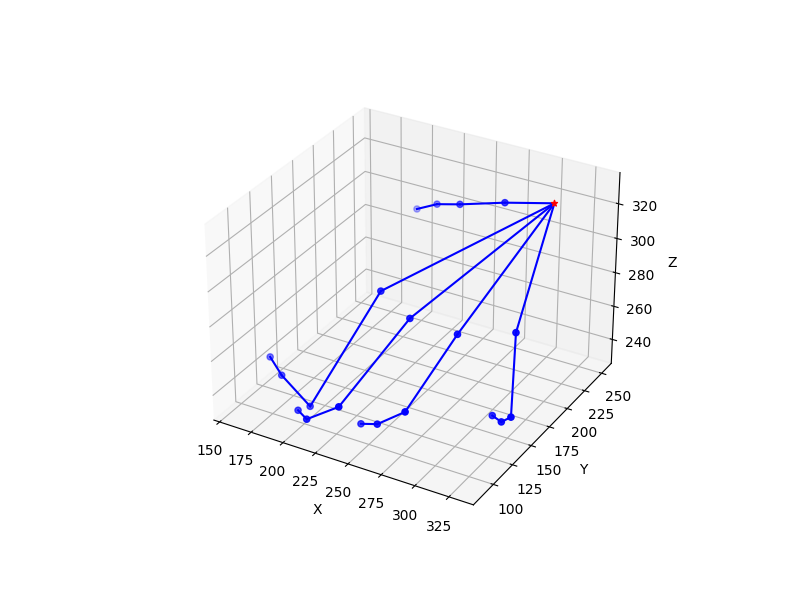

In [35]:
plot_3d(rs_xyZ[:, 0], rs_xyZ[:, 1], rs_xyZ[:, 2])

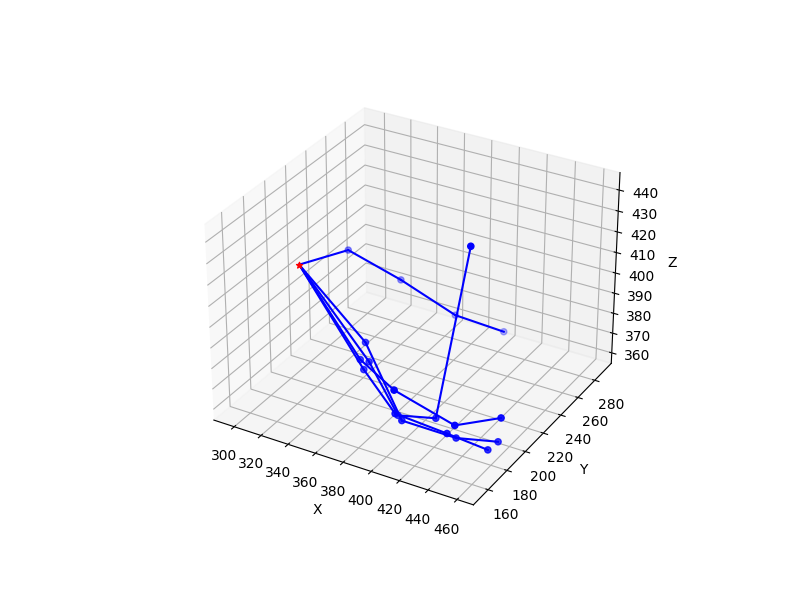

In [36]:
plot_3d(oak_xyZ[:, 0], oak_xyZ[:, 1], oak_xyZ[:, 2])

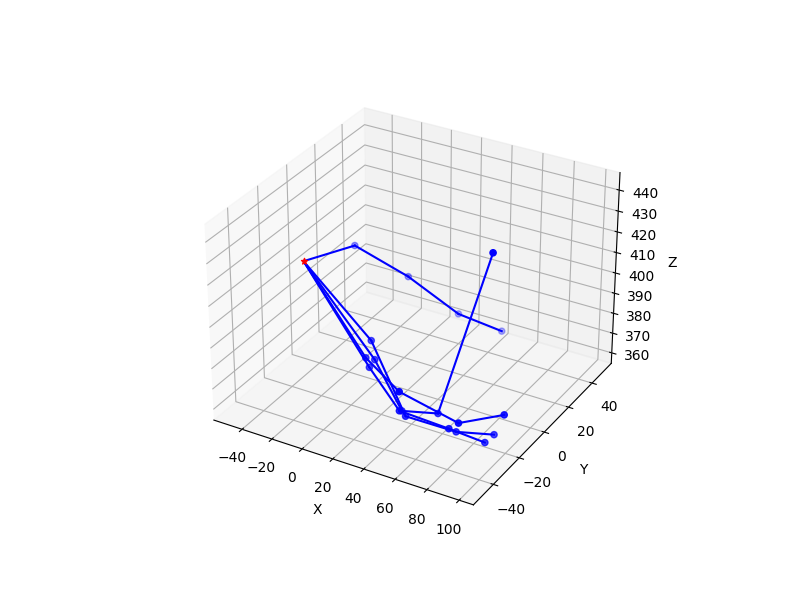

In [37]:
plot_3d(oak_XYZ[:, 0], oak_XYZ[:, 1], oak_XYZ[:, 2])

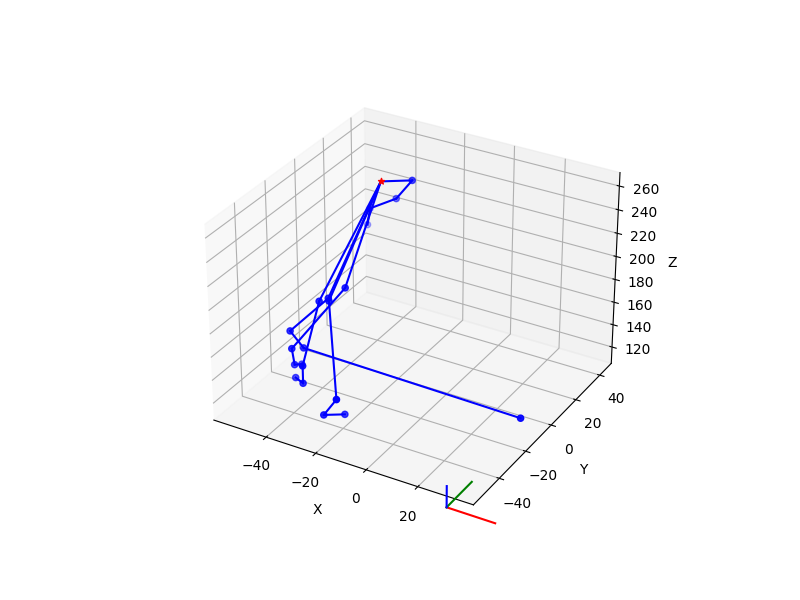

In [38]:
plot_3d(oak_XYZ_in_rs[:, 0], oak_XYZ_in_rs[:, 1], oak_XYZ_in_rs[:, 2])

In [39]:
oak_XYZ_in_rs.shape

(21, 3)

In [40]:
def distance(Z, oak_xyZ, rs_xyZ, oak_ins, rs_ins):
    oak_Z, rs_Z = Z
    oak_XYZ = np.zeros_like(oak_xyZ)
    rs_XYZ = np.zeros_like(rs_xyZ)
    
    oak_XYZ[0] = (oak_xyZ[0] - oak_ins[0, -1]) * oak_Z / oak_ins[0, 0]
    oak_XYZ[1] = (oak_xyZ[1] - oak_ins[1, -1]) * oak_Z / oak_ins[1, 1]
    oak_XYZ[-1] = oak_Z

    rs_XYZ[0] = (rs_xyZ[0] - rs_ins[0, -1]) * rs_Z / rs_ins[0, 0]
    rs_XYZ[1] = (rs_xyZ[1] - rs_ins[1, -1]) * rs_Z / rs_ins[1, 1]
    rs_XYZ[-1] = rs_Z

    #homo = np.ones(shape=oak_XYZ.shape[0])
    oak_XYZ_homo = np.concatenate([oak_XYZ, [1]])
    oak_XYZ_in_rs = np.matmul(oak_2_rs_mat_avg, oak_XYZ_homo.T)
    oak_XYZ_in_rs = oak_XYZ_in_rs[:-1]

    return euclidean(oak_XYZ_in_rs, rs_XYZ)

In [41]:
oak_new_Z, rs_new_Z = [], []

for i in range(oak_xyZ.shape[0]):
    oak_i_xyZ, rs_i_xyZ = oak_xyZ[i], rs_xyZ[i]

    min_dis = partial(distance, oak_xyZ=oak_i_xyZ, rs_xyZ=rs_i_xyZ, oak_ins=oak_ins, rs_ins=rs_ins)
    result = minimize(min_dis, x0=[oak_i_xyZ[-1], rs_i_xyZ[-1]])
    oak_i_new_Z, rs_i_new_Z = result.x
    oak_new_Z.append(oak_i_new_Z)
    rs_new_Z.append(rs_i_new_Z)

In [42]:
oak_new_xyZ = oak_xyZ.copy()
rs_new_xyZ = rs_xyZ.copy()

oak_new_xyZ[:, -1] = oak_new_Z
rs_new_xyZ[:, -1] = rs_new_Z

In [43]:
oak_new_XYZ = np.zeros_like(oak_new_xyZ)
rs_new_XYZ = np.zeros_like(rs_new_xyZ)

In [44]:
oak_new_XYZ[:, 0] = (oak_new_xyZ[:, 0] - oak_ins[0, -1]) * oak_new_xyZ[:, -1] / oak_ins[0, 0]
oak_new_XYZ[:, 1] = (oak_new_xyZ[:, 1] - oak_ins[1, -1]) * oak_new_xyZ[:, -1] / oak_ins[1, 1]
oak_new_XYZ[:, -1] = oak_new_xyZ[:, -1]

In [45]:
rs_new_XYZ[:, 0] = (rs_new_xyZ[:, 0] - rs_ins[0, -1]) * rs_new_xyZ[:, -1] / rs_ins[0, 0]
rs_new_XYZ[:, 1] = (rs_new_xyZ[:, 1] - rs_ins[1, -1]) * rs_new_xyZ[:, -1] / rs_ins[1, 1]
rs_new_XYZ[:, -1] = rs_new_xyZ[:, -1]

In [46]:
oak_new_XYZ.shape

(21, 3)

In [47]:
rs_new_XYZ.shape

(21, 3)

In [48]:
landmarks = (oak_new_XYZ + rs_new_XYZ) / 2

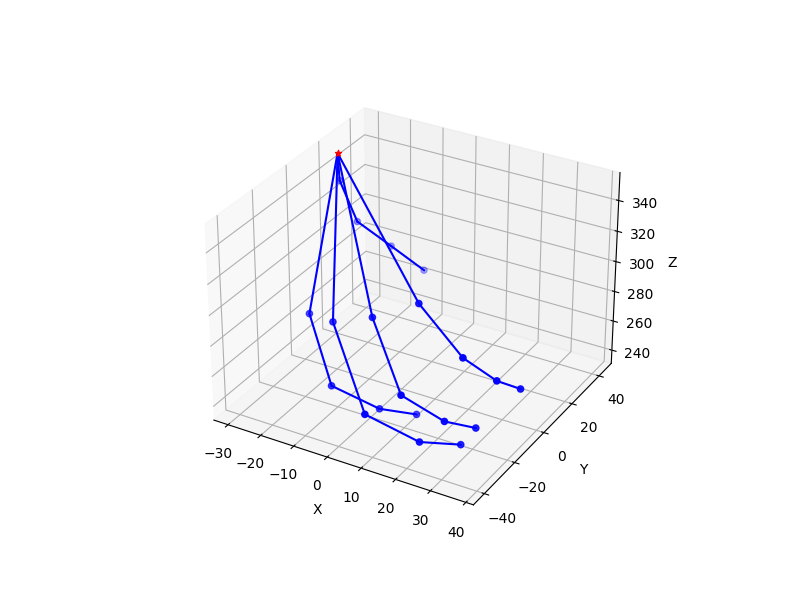

In [49]:
plot_3d(landmarks[:, 0], landmarks[:, 1], landmarks[:, 2])

In [51]:
finger_joints_names = [
    "WRIST",
    "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP",
    "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP",
    "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP",
    "RING_FINGER_MCP", "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP",
    "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
]

In [53]:
u = landmarks[finger_joints_names.index("INDEX_FINGER_MCP"), :] - landmarks[finger_joints_names.index("WRIST"), :]
y = landmarks[finger_joints_names.index("MIDDLE_FINGER_MCP"), :] - landmarks[finger_joints_names.index("WRIST"), :]

x = np.cross(y, u)
z = np.cross(x, y)

x = x / np.linalg.norm(x)
y = y / np.linalg.norm(y)
z = z / np.linalg.norm(z)

w_c = landmarks[finger_joints_names.index("WRIST"), :]

R = np.array([x, y, z, w_c])
R = np.concatenate([R, np.expand_dims([0, 0, 0, 1], 1)], axis=1)
R = np.transpose(R)
R_inv = np.linalg.inv(R)

In [54]:
homo = np.ones(shape=landmarks.shape[0])
landmarks = np.concatenate([landmarks, np.expand_dims(homo, 1)], axis=1)
landmarks_wrt_wrist = np.matmul(R_inv, np.transpose(landmarks))
landmarks_wrt_wrist = np.transpose(landmarks_wrt_wrist)

In [55]:
wrist_coords, fingers_landmarks_wrt_wrist = landmarks_wrt_wrist[0, :-1], landmarks_wrt_wrist[1:, :-1]
fingers_landmarks_wrt_wrist = fingers_landmarks_wrt_wrist.reshape(5, 4, 3)

In [58]:
def plot_3d(origin_coords, x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(origin_coords[0], origin_coords[1], origin_coords[2], c='r', marker='*')
    ax.scatter(x.flatten(), y.flatten(), z.flatten(), c='b', marker='o')
    
    # Draw a line
    def draw_line(ax, prev_p, next_p):
        ax.plot([prev_p[0], next_p[0]], [prev_p[1], next_p[1]], [prev_p[2], next_p[2]], c='b')
        return ax

    for finger_i in range(x.shape[0]):
        for joint_j in range(x.shape[1]):
            if joint_j == 0:
                prev_p = origin_coords
            else:
                prev_p = next_p
            next_p = [x[finger_i, joint_j], y[finger_i, joint_j], z[finger_i, joint_j]]
            ax = draw_line(ax, prev_p, next_p)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the limits for each axis
    #ax.set_xlim(-20, 150)
    #ax.set_ylim(0, 200)
    #ax.set_zlim(-20, 100)  # Setting custom limits for z-axis

    plt.show()

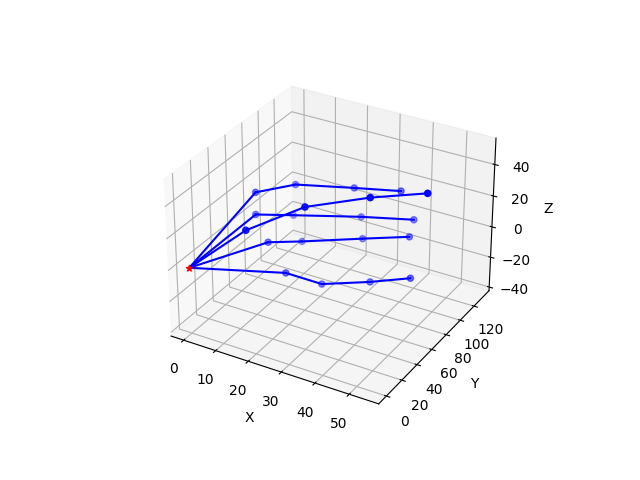

In [59]:
plot_3d(wrist_coords,
        fingers_landmarks_wrt_wrist[:, :, 0], 
        fingers_landmarks_wrt_wrist[:, :, 1], 
        fingers_landmarks_wrt_wrist[:, :, 2])